covid deaths, solar weekly, tourism
monthly, australian electricity demand, pedestrian counts, traffic hourly, hospital, fred md, tourism
yearly, tourism quarterly, us births,nn5 weekly,solar 10 minutes, traffic weekly, saugeenday, cif 2016.

In [33]:
import pandas as pd
import datasets
from datasets import load_dataset

In [117]:
datasets_name = ['covid_deaths',
                 'solar_weekly',
                 'tourism_monthly',
                 'australian_electricity_demand',
                 'pedestrian_counts',
                 'traffic_hourly',
                 'hospital',
                 'fred_md',
                 'tourism_yearly',
                 'tourism_quarterly',
                 'us_births',
                 'nn5_weekly',
                 'solar_10_minutes',
                 'traffic_weekly',
                 'saugeenday',
                 'cif_2016',]
output_dir = 'D:/edge_download/llmtime-main/datasets/monash/'
for name in datasets_name:
    dataAll = load_dataset("monash_tsf", name)
    df = pd.DataFrame(dataAll['train'][0]['target'], columns=['data'])
    df.to_csv(output_dir + name + '.csv', index=False)
    print(name + 'saved')

covid_deathssaved


Generating validation split: 100%|██████████| 137/137 [00:00<00:00, 5095.14 examples/s]


solar_weeklysaved
tourism_monthlysaved


Generating validation split: 100%|██████████| 5/5 [00:01<00:00,  3.26 examples/s]


australian_electricity_demandsaved


Generating validation split: 100%|██████████| 66/66 [00:04<00:00, 15.67 examples/s]


pedestrian_countssaved


Generating validation split: 100%|██████████| 862/862 [00:21<00:00, 40.22 examples/s]


traffic_hourlysaved


Generating validation split: 100%|██████████| 767/767 [00:00<00:00, 4157.41 examples/s]


hospitalsaved


Generating validation split: 100%|██████████| 107/107 [00:00<00:00, 825.09 examples/s]


fred_mdsaved
tourism_yearlysaved
tourism_quarterlysaved


Generating validation split: 100%|██████████| 1/1 [00:00<00:00, 65.86 examples/s]


us_birthssaved


Generating validation split: 100%|██████████| 111/111 [00:00<00:00, 3746.75 examples/s]


nn5_weeklysaved


Generating validation split: 100%|██████████| 137/137 [00:09<00:00, 15.13 examples/s]


solar_10_minutessaved


Generating validation split: 100%|██████████| 862/862 [00:00<00:00, 4163.74 examples/s]


traffic_weeklysaved


Generating validation split: 100%|██████████| 1/1 [00:00<00:00, 26.88 examples/s]


saugeendaysaved
cif_2016saved


In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
# openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_key = 'your api key'

from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

d:\software\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def plot_preds(train, test, pred_dict, model_name, mse, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(model_name)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    mse_name = model_name + '_mse'
    # plt.text(0.03, 0.85, f'{mse_name}: {mse:.2f} ')
    plt.text(0.03, 0.85, f'{mse_name}: {mse:.2f} ', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # if 'NLL/D' in pred_dict:
    #     nll = pred_dict['NLL/D']
    #     if nll is not None:
    #         plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [3]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    # 'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    # 'PromptCast GPT-3.5':{'model': 'gpt-3.5-turbo-instruct', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [4]:
from sklearn.metrics import mean_squared_error
def out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names):
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        
        pred = pred_dict['median']
        pred = pd.Series(pred, index=test.index)
        mse = mean_squared_error(test, pred)
        out[model+"_mse"] = mse
        plot_preds(train, test, pred_dict, model, mse, show_samples=False)
    return out

In [42]:
import random
def result(ds_name):
    # ds_name = 'tourism_monthly'
    df = pd.read_csv('D:/edge_download/llmtime-main/datasets/monash/'+ ds_name+'.csv')
    data = df.data # or change to your own data
    print('before data length:',len(data))
    if len(data) > 500:   
        random_number = random.randint(0, len(data)-500)
        data = data[random_number:random_number+500]
    print('after data length:',len(data))
    testfrac = 0.2
    splitpoint = int(len(data)*(1-testfrac))
    train = data.iloc[:splitpoint]
    test = data.iloc[splitpoint:]
    print('test length:', len(test))
    res = out(train, test, ds_name)
    print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
    print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# covid_deaths

before data length: 152
after data length: 152
test length: 31


100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


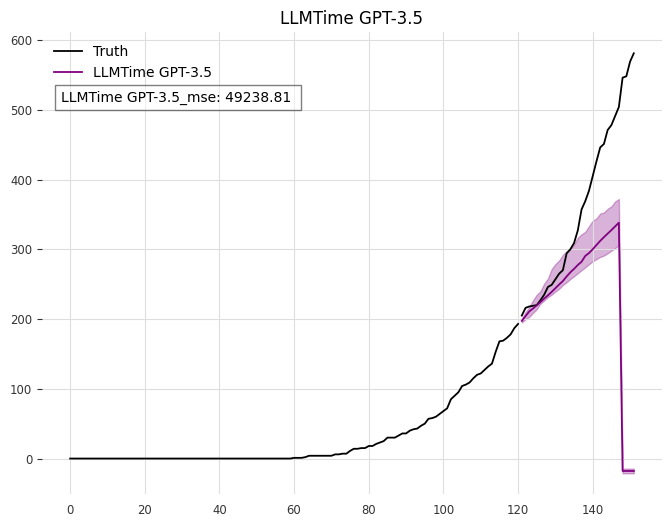

Train length: 90, Val length: 31


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparamet

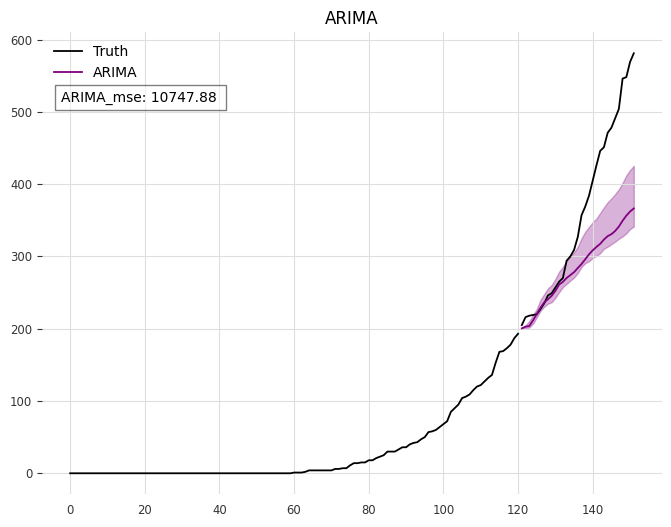

covid_deaths_LLMTime GPT-3.5_mse: 49238.8142929216
covid_deaths_ARIMA_mse: 10747.878627798616


In [44]:
ds_name = 'covid_deaths'
result(ds_name)

# solar_weekly

In [43]:
ds_name = 'solar_weekly'

data length: 42
test length: 9


# tourism_monthly

before data length: 139
after data length: 139
test length: 28


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


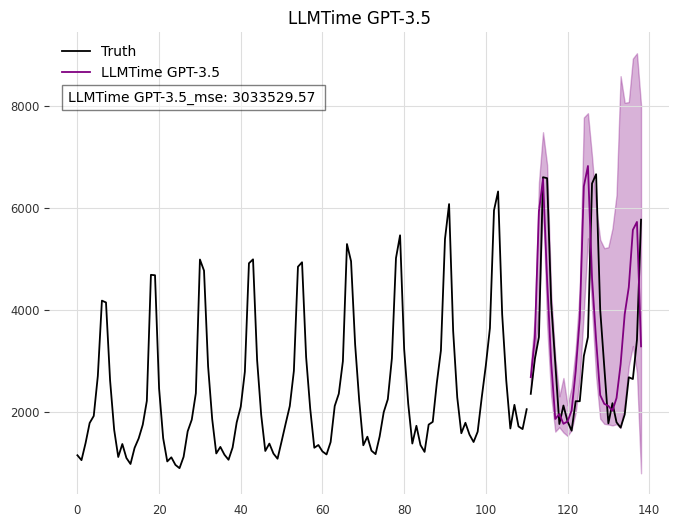

Train length: 83, Val length: 28


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparamet

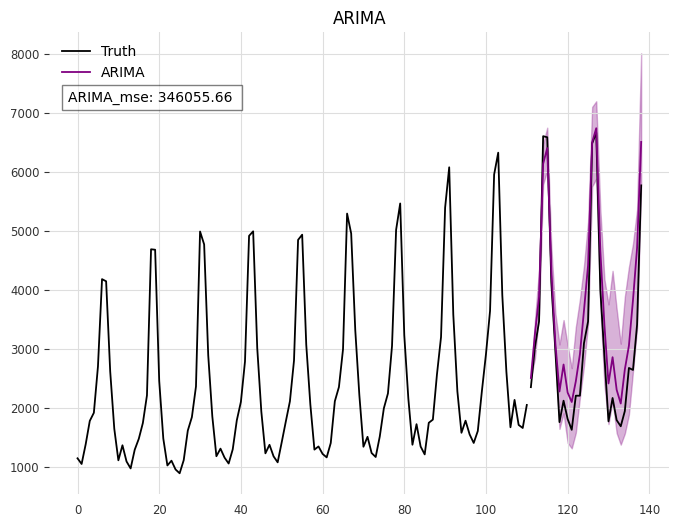

tourism_monthly_LLMTime GPT-3.5_mse: 3033529.567628452
tourism_monthly_ARIMA_mse: 346055.6619205152


In [45]:
ds_name = 'tourism_monthly'
result(ds_name)

# australian_electricity_demand

before data length: 230616
after data length: 500
test length: 100


100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


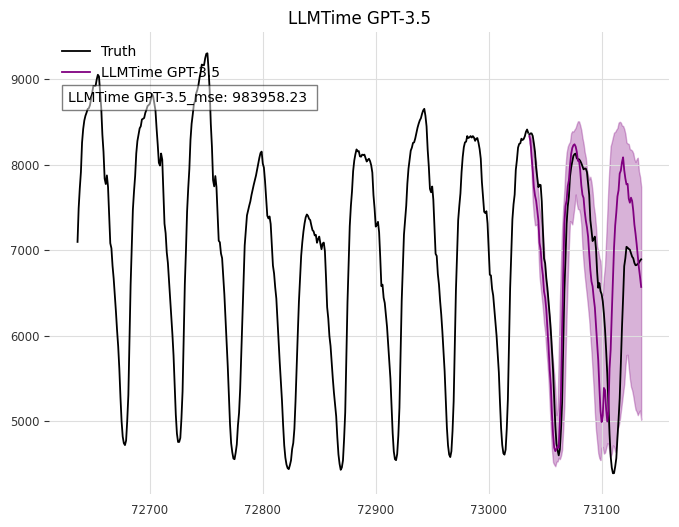

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:02<00:03,  1.59s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:15<00:06,  6.81s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

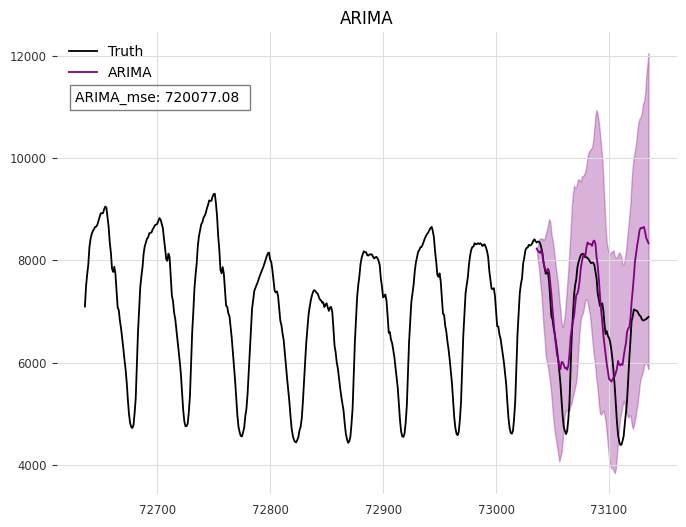

australian_electricity_demand_LLMTime GPT-3.5_mse: 983958.2285267864
australian_electricity_demand_ARIMA_mse: 720077.0844885743


In [46]:
ds_name = 'australian_electricity_demand'
result(ds_name)

# pedestrian_counts

before data length: 84235
after data length: 500
test length: 100


100%|██████████| 1/1 [00:13<00:00, 13.17s/it]


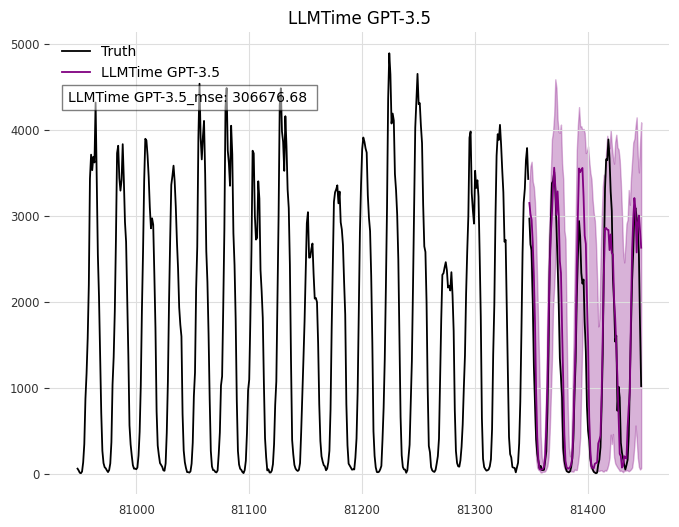

Train length: 300, Val length: 100


Hyperparameter search:  25%|██▌       | 1/4 [00:00<00:02,  1.44it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  50%|█████     | 2/4 [00:02<00:03,  1.62s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

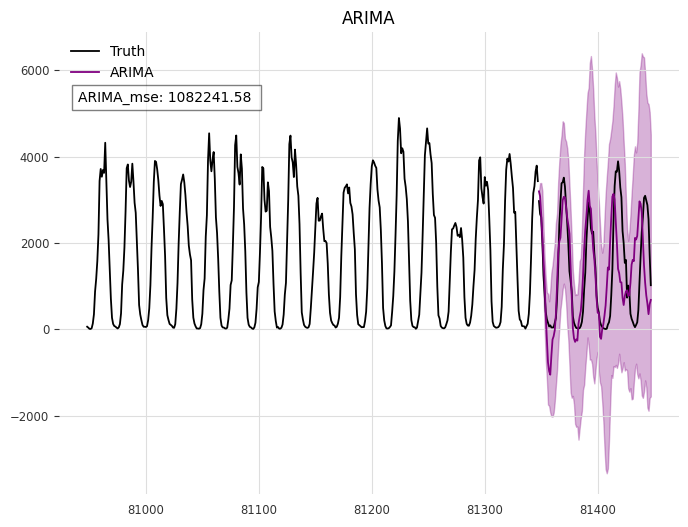

pedestrian_counts_LLMTime GPT-3.5_mse: 306676.6754300605
pedestrian_counts_ARIMA_mse: 1082241.5828285445


In [47]:
ds_name = 'pedestrian_counts'
result(ds_name)

# traffic_hourly

before data length: 17448
after data length: 500
test length: 100


100%|██████████| 1/1 [00:13<00:00, 13.47s/it]


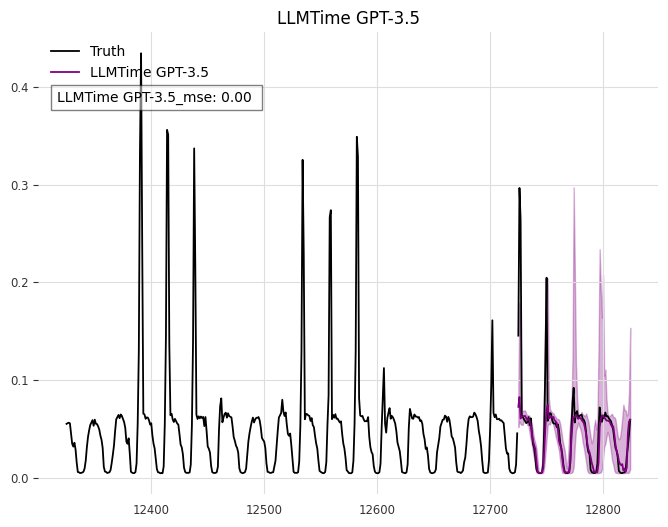

Train length: 300, Val length: 100


Hyperparameter search: 100%|██████████| 4/4 [00:22<00:00,  5.67s/it]


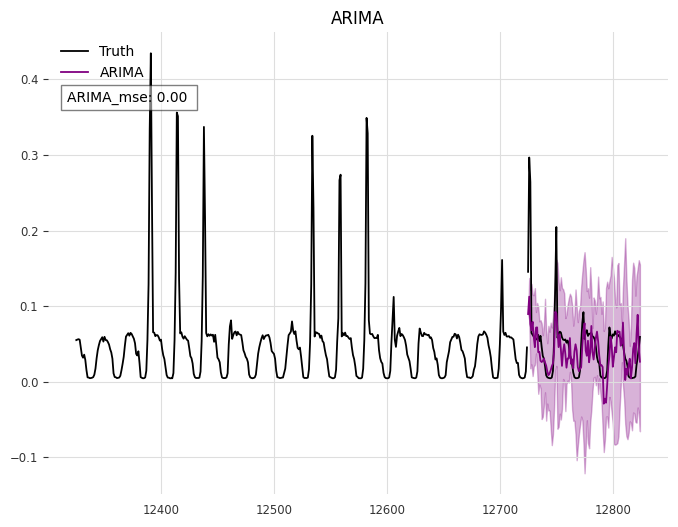

traffic_hourly_LLMTime GPT-3.5_mse: 0.0012187888568380766
traffic_hourly_ARIMA_mse: 0.001341066852820638


In [48]:
ds_name = 'traffic_hourly'
result(ds_name)

# hospital

before data length: 60
after data length: 60
test length: 12


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


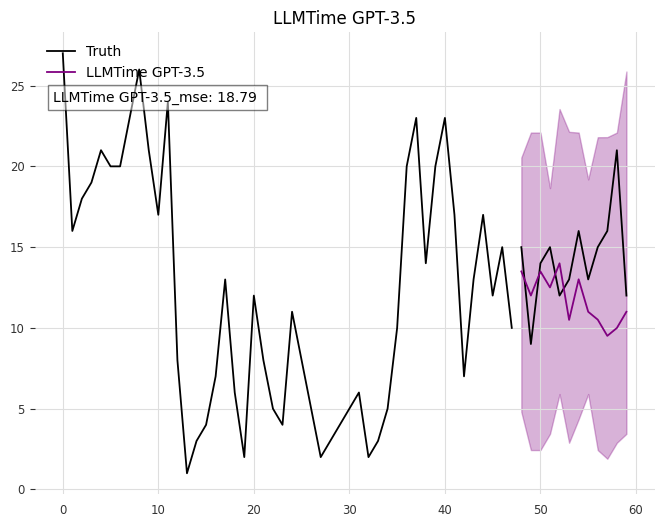

Train length: 36, Val length: 12


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  50%|█████     | 2/4 [00:02<00:02,  1.00s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

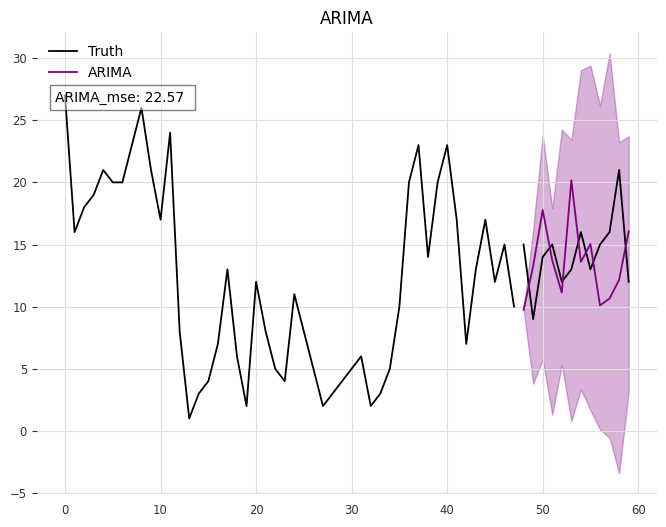

hospital_LLMTime GPT-3.5_mse: 18.788615099010432
hospital_ARIMA_mse: 22.5716450830307


In [49]:
ds_name = 'hospital'
result(ds_name)

# fred_md

before data length: 704
after data length: 500
test length: 100


100%|██████████| 1/1 [00:11<00:00, 11.95s/it]


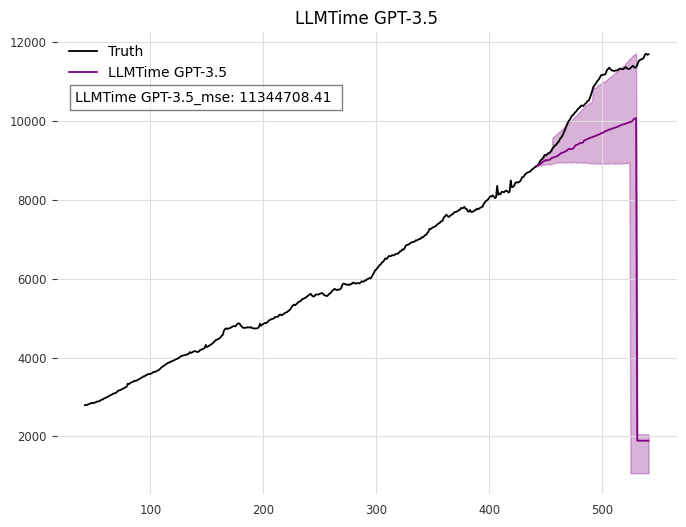

Train length: 300, Val length: 100


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:08<00:03,  3.21s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

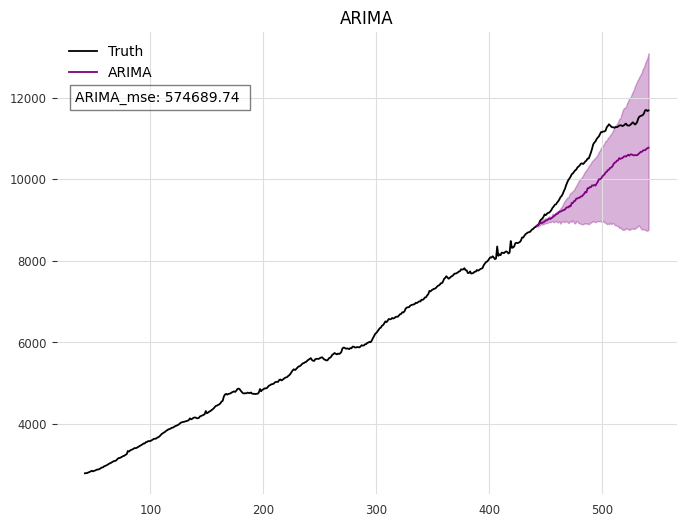

fred_md_LLMTime GPT-3.5_mse: 11344708.41315123
fred_md_ARIMA_mse: 574689.7357257422


In [50]:
ds_name = 'fred_md'
result(ds_name)

# tourism_yearly

# tourism_quarterly

In [51]:
# ds_name = 'tourism_quarterly'
# result(ds_name) 

# us_births

before data length: 7245
after data length: 500
test length: 100


100%|██████████| 1/1 [00:12<00:00, 12.62s/it]


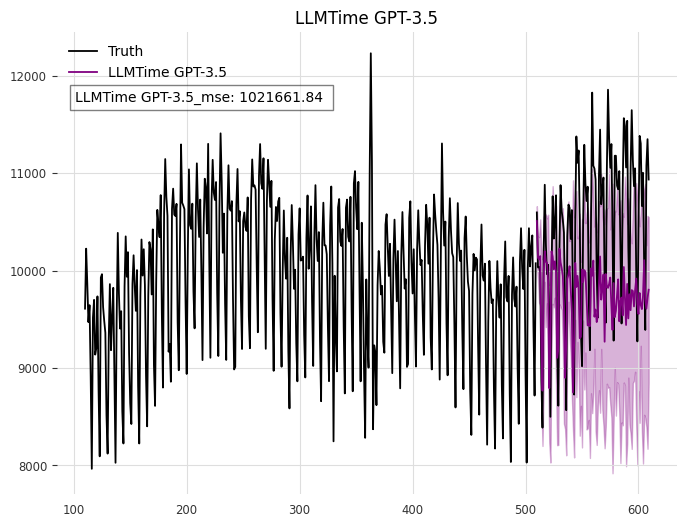

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:04<00:04,  2.04s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:16<00:06,  6.87s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

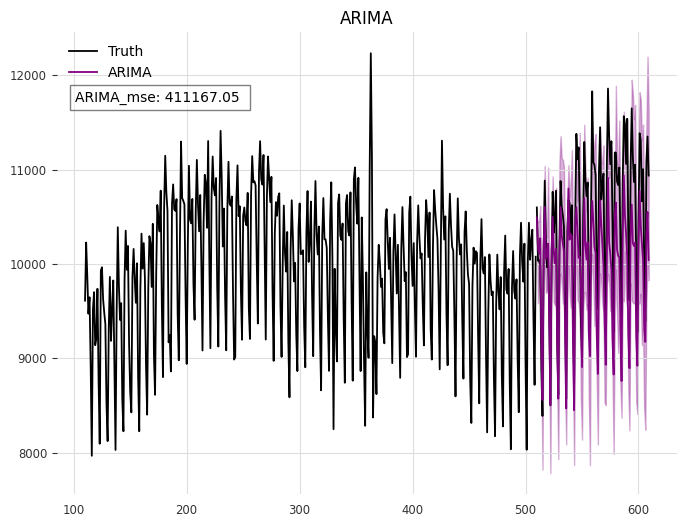

us_births_LLMTime GPT-3.5_mse: 1021661.8389775754
us_births_ARIMA_mse: 411167.0493520772


In [54]:
ds_name = 'us_births'
result(ds_name)

# nn5_weekly

before data length: 97
after data length: 97
test length: 20


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


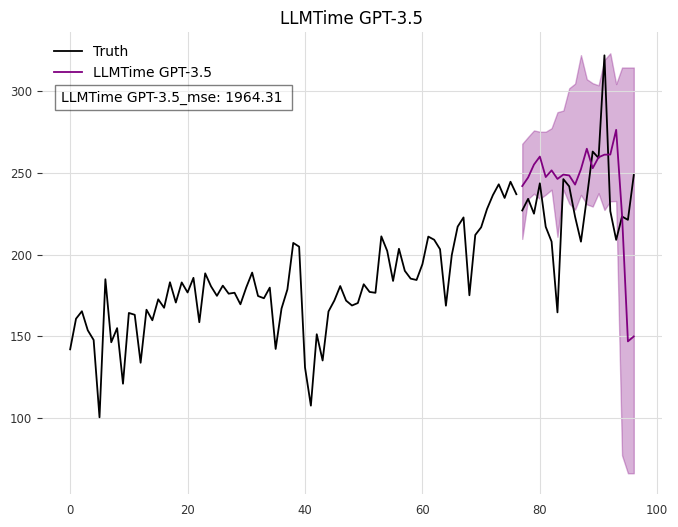

Train length: 57, Val length: 20


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.42it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
Hyperparameter search:  75%|███████▌  | 3/4 [00:03<00:01,  1.36s/it]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressi

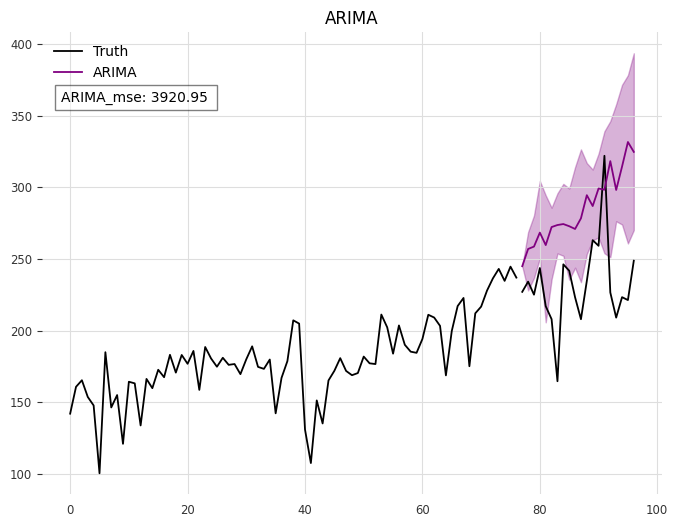

nn5_weekly_LLMTime GPT-3.5_mse: 1964.305655571033
nn5_weekly_ARIMA_mse: 3920.950261881286


In [52]:
ds_name = 'nn5_weekly'
result(ds_name)

# solar_10_minutes

# traffic_weekly

before data length: 88
after data length: 88
test length: 18


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


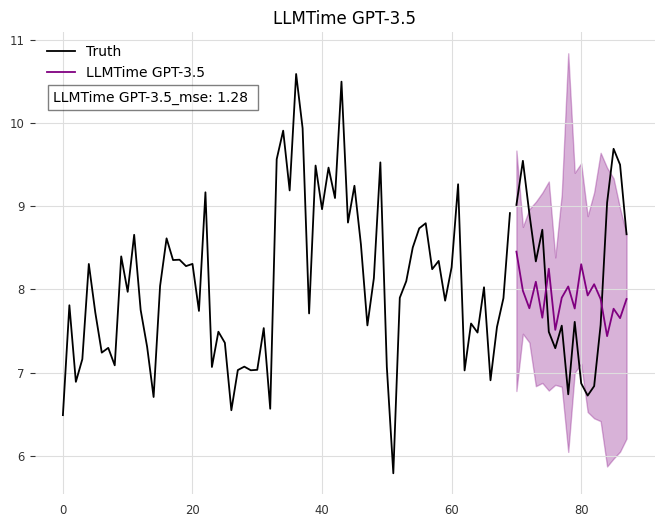

Train length: 52, Val length: 18


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.31it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
Hyperparameter search:  75%|███████▌  | 3/4 [00:03<00:01,  1.37s/it]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to

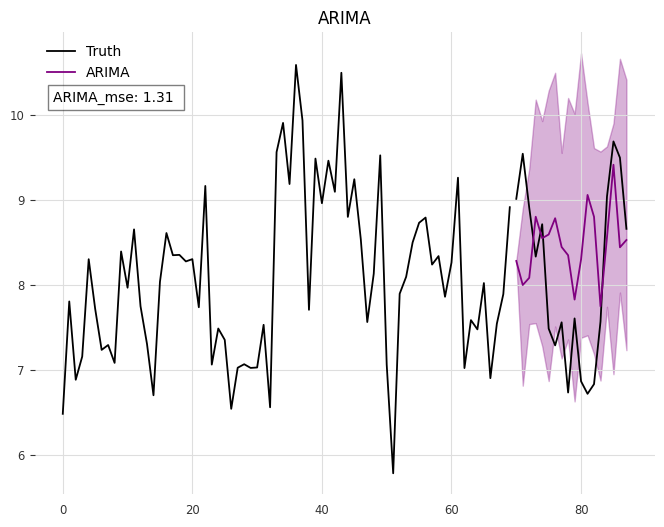

traffic_weekly_LLMTime GPT-3.5_mse: 1.282437706433302
traffic_weekly_ARIMA_mse: 1.3123734125321846


In [53]:
ds_name = 'traffic_weekly'
result(ds_name)

# saugeenday 

# cif_2016

data length: 96
test length: 20




100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


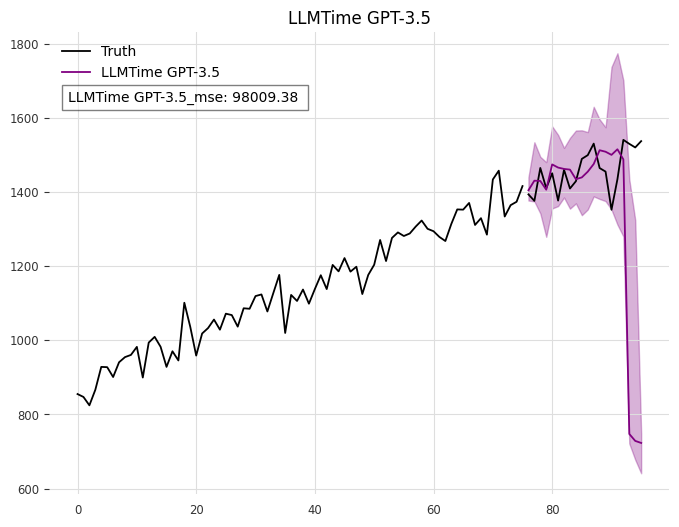

Train length: 56, Val length: 20





d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\stats

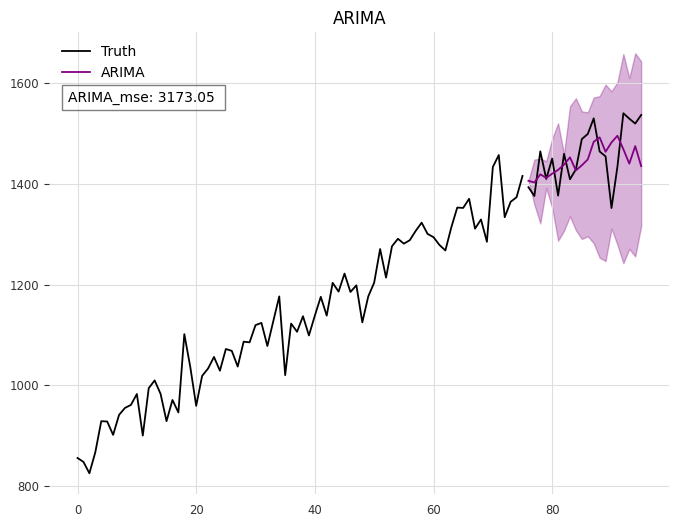

cif_2016_LLMTime GPT-3.5_mse: 98009.37814923668
cif_2016_ARIMA_mse: 3173.0464712897146


In [39]:
result('cif_2016')